In [1]:
#########################################################################################################
# An r-adaptive finite element method using neural networks for parametric self-adjoint elliptic problems
# Author: Danilo Aballay, Federico Fuentes, Vicente Iligaray, Ángel J. Omella,
#         David Pardo, Manuel A. Sánchez, Ignacio Tapia, Carlos Uriarte
#########################################################################################################


import jax.numpy as jnp
from jax import random, grad, jit, vmap
import jax
import jax.nn as nn
import numpy as np
from jax.example_libraries import optimizers
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
from fem_system import solve, solve_and_loss, solve_and_loss_scipy, build_system_vmap

os.environ["TF_ENABLE_ONEDNN_OPTS"] = "1"
os.environ["JAX_PLATFORMS"] = "cpu"
os.environ["KERAS_BACKEND"] = "jax"
import keras

# Set the random seed
keras.utils.set_random_seed(1234)

dtype='float64' # double precision set to default in the SCR functions
jax.config.update("jax_enable_x64", True)
keras.backend.set_floatx(dtype)


sys.path.append(os.path.abspath('..'))
key = jax.random.PRNGKey(0)


## Import dataset

In [2]:
dataset       = np.array(pd.read_csv('Dataset/dataset.csv').values)
train_indices = np.array(pd.read_csv('Dataset/train_indices.csv').train_indices)
test_indices  = np.array(pd.read_csv('Dataset/test_indices.csv').test_indices)

train_data   = dataset[train_indices]
test_data    = dataset[test_indices]
subset_test  = np.array(pd.read_csv('Dataset/test_subset.csv').values)

### Rutina para guardar el Ritz usando grilla uniforme


In [3]:
from scipy.integrate import dblquad, quad
import numpy as onp

def Exact_Ritz(alpha, sx, sy):
    u      = lambda x, y: (onp.arctan(alpha*(x - sx)) + onp.arctan(alpha*sx))*(onp.arctan(alpha*(y - sy)) + onp.arctan(alpha*sy))
    f      = lambda x, y: (onp.arctan(alpha*(y - sy)) + onp.arctan(alpha*sy))*2*alpha**2*(alpha*(x-sx))/(1 + (alpha*(x - sx))**2)**2 \
          + (onp.arctan(alpha*(x - sx)) + onp.arctan(alpha*sx))*2*alpha**2*(alpha*(y-sy))/(1 + (alpha*(y - sy))**2)**2
    gu     = lambda x, y: (onp.arctan(alpha*(x-sx)) + onp.arctan(alpha*sx)) * alpha / (1 + (alpha*(y-sy))**2)
    gt     = lambda x, y: (onp.arctan(alpha*(y-sy)) + onp.arctan(alpha*sy)) * alpha / (1 + (alpha*(x-sx))**2) 
    gradu = lambda x, y: gu(x, y)**2 + gt(x, y)**2

    neum1 = quad(lambda x: u(x, 1)*gu(x, 1), 0, 1)
    neum2 = quad(lambda x: u(1, x)*gt(1, x), 0, 1)

    fun = lambda y, x: 0.5*gradu(x, y) - u(x, y)*f(x, y) 
    return dblquad(fun, 0, 1, 0, 1)[0] - neum1[0] - neum2[0]

In [4]:
# Define the number of nodes
n_nodes       = 2*9 # 2*(number of elements [N])
uniform_grid  = jnp.concatenate([jnp.linspace(0, 1, n_nodes//2 + 1), jnp.linspace(0, 1, n_nodes//2 + 1)])

In [5]:
# Compute the ritz value with uniform mesh for training set
ritz_dict_train = {str(a): solve_and_loss_scipy(uniform_grid, a.reshape(-1,3)) for a in np.concatenate((train_data, subset_test))}

# Compute the ritz value with uniform mesh for test set
ritz_dict_val = {str(a): solve_and_loss_scipy(uniform_grid, a.reshape(-1,3)) for a in test_data}

### Neural Network

In [6]:
# Neural Network parameters

def init_params(layers, key):
    Ws = []
    bs = []
    for i in range(len(layers) - 1):
        std_lecun = jnp.sqrt(1 / layers[i])
        key, subkey = random.split(key)
        Ws.append(random.normal(subkey, (layers[i], layers[i + 1])) * std_lecun)
        bs.append(jnp.zeros(layers[i + 1]))
    return [Ws, bs]

@jit
def forward_pass(A_t, params):
    Ws, bs = params
    H = A_t
    for i in range(len(Ws) - 1):
        H = jnp.matmul(H, Ws[i]) + bs[i]
        H = jnp.tanh(H)
    nodes_ = jnp.matmul(H, Ws[-1]) + bs[-1]
    n_n = nodes_.size
    thetax = nn.softmax(nodes_[:n_n//2])
    thetay = nn.softmax(nodes_[n_n//2:])
    nodesx = jnp.cumsum(thetax)
    nodesx = jnp.insert(nodesx, 0, 0)
    nodesy = jnp.cumsum(thetay)
    nodesy = jnp.insert(nodesy, 0, 0)
    return jnp.concatenate([nodesx, nodesy])

def loss(params, alphas):
    losses = solve_and_loss_scipy(forward_pass(alphas[0], params), alphas[0].reshape(-1, 3))
    return jnp.array([losses[i] / abs(ritz_dict_train[str(alpha)]) for i, alpha in enumerate(alphas)]).mean()

def loss_test(params, alphas, J_u):
    temp = 0
    for i in range(len(alphas)):
        val = solve_and_loss_scipy(forward_pass(alphas[i,:], params), alphas[i,:].reshape(-1, 3)).item()
        temp += np.sqrt(abs((J_u[i]-val)/J_u[i]))
    return temp/len(alphas)

def FEM_sol(params, alpha):
    nodes = forward_pass(alpha, params)
    return solve(nodes, jnp.squeeze(alpha))

def train(loss_fn, opt_state, alphas, test_subset, n_epochs=10, n_iter_per_epoch=1000, batch_size=1, lr=1e-2):
    train_loss = []
    test_loss  = []
    test_loss_epoch = []
    J_u        = jnp.array([Exact_Ritz(subset_test[i,0], subset_test[i,1], subset_test[i,2]) for i in range(len(subset_test))])
    key = random.PRNGKey(100)
    n_alphas = alphas.shape[0]
    opt_init, opt_update, get_params = optimizers.adam(lr)
    params   = get_params(opt_state)
    test_loss_save_interval = 100
    
    for epoch in range(n_epochs):
        key, subkey = random.split(key)
        idx = random.choice(subkey, n_alphas, (batch_size,), replace=False)
        sigma_batch = alphas[idx]

        for it in range(n_iter_per_epoch):
            params    = get_params(opt_state)
            grads     = grad(loss_fn)(params, sigma_batch)
            opt_state = opt_update(0, grads, opt_state)

        if epoch == 100:
            test_loss_save_interval = 10
        if epoch == 1000:
            test_loss_save_interval = 100
        if epoch == 10000:
            test_loss_save_interval = 1000

        if epoch == 210000:
            lr  = 1e-3
            opt_init, opt_update, get_params = optimizers.adam(lr)
            opt_state = opt_init(params)
        
        params = get_params(opt_state)
        loss_val = loss_fn(params, sigma_batch)
        train_loss.append(loss_val)

        if epoch % test_loss_save_interval == 0:
            test_loss_epoch.append(epoch)
            test_loss.append(loss_test(params, test_subset, J_u))
            print(f"Epoch {epoch}, Training loss: {loss_val:.4e}, Test loss: {test_loss[-1]:.4e}, Learning rate: {lr:.4e}")

    return get_params(opt_state), opt_state, train_loss, test_loss, test_loss_epoch


### Training

In [7]:
# Network parameters and training configuration
iter       = 1  # Number of iterations per epoch
epochs     = 15000
lr         = 1e-2
batch_size = 1

# Define the neural network architecture
layers = [3, 10, 10, n_nodes]
key    = random.PRNGKey(42)

# Initialize the optimizer and parameters
opt_init, opt_update, get_params = optimizers.adam(lr)
params    = init_params(layers, key)
opt_state = opt_init(params)

# Train the model
trained_param, opt_state_save, trained_error, test_loss, test_loss_epoch = train(loss, opt_state, jnp.array(train_data), jnp.array(subset_test), epochs, iter, batch_size, lr)

Epoch 0, Training loss: -9.7911e-01, Test loss: 3.1196e-01, Learning rate: 1.0000e-02
Epoch 100, Training loss: -1.0229e+00, Test loss: 3.3281e-01, Learning rate: 1.0000e-02
Epoch 110, Training loss: -9.9990e-01, Test loss: 3.4729e-01, Learning rate: 1.0000e-02
Epoch 120, Training loss: -9.9959e-01, Test loss: 3.4303e-01, Learning rate: 1.0000e-02
Epoch 130, Training loss: -1.1521e+00, Test loss: 3.2250e-01, Learning rate: 1.0000e-02
Epoch 140, Training loss: -9.5542e-01, Test loss: 3.1677e-01, Learning rate: 1.0000e-02
Epoch 150, Training loss: -9.6543e-01, Test loss: 3.1297e-01, Learning rate: 1.0000e-02
Epoch 160, Training loss: -9.7164e-01, Test loss: 2.8255e-01, Learning rate: 1.0000e-02
Epoch 170, Training loss: -9.8283e-01, Test loss: 2.8608e-01, Learning rate: 1.0000e-02
Epoch 180, Training loss: -1.0092e+00, Test loss: 2.8736e-01, Learning rate: 1.0000e-02
Epoch 190, Training loss: -9.5988e-01, Test loss: 2.9088e-01, Learning rate: 1.0000e-02
Epoch 200, Training loss: -1.0283e

Text(0.5, 1.0, 'Monitoring Error')

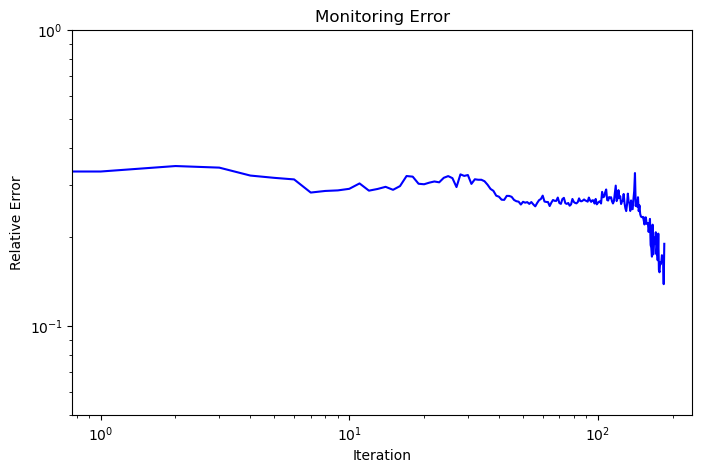

In [8]:
fig, axs = plt.subplots(1, 1, figsize=(8, 5))
axs.plot(test_loss, color='blue')
axs.set_ylim(5e-2, 1e0)
axs.set_xlabel('Iteration')
axs.set_ylabel('Relative Error')
axs.set_xscale('log')
axs.set_yscale('log')
axs.set_title('Monitoring Error')

### Test

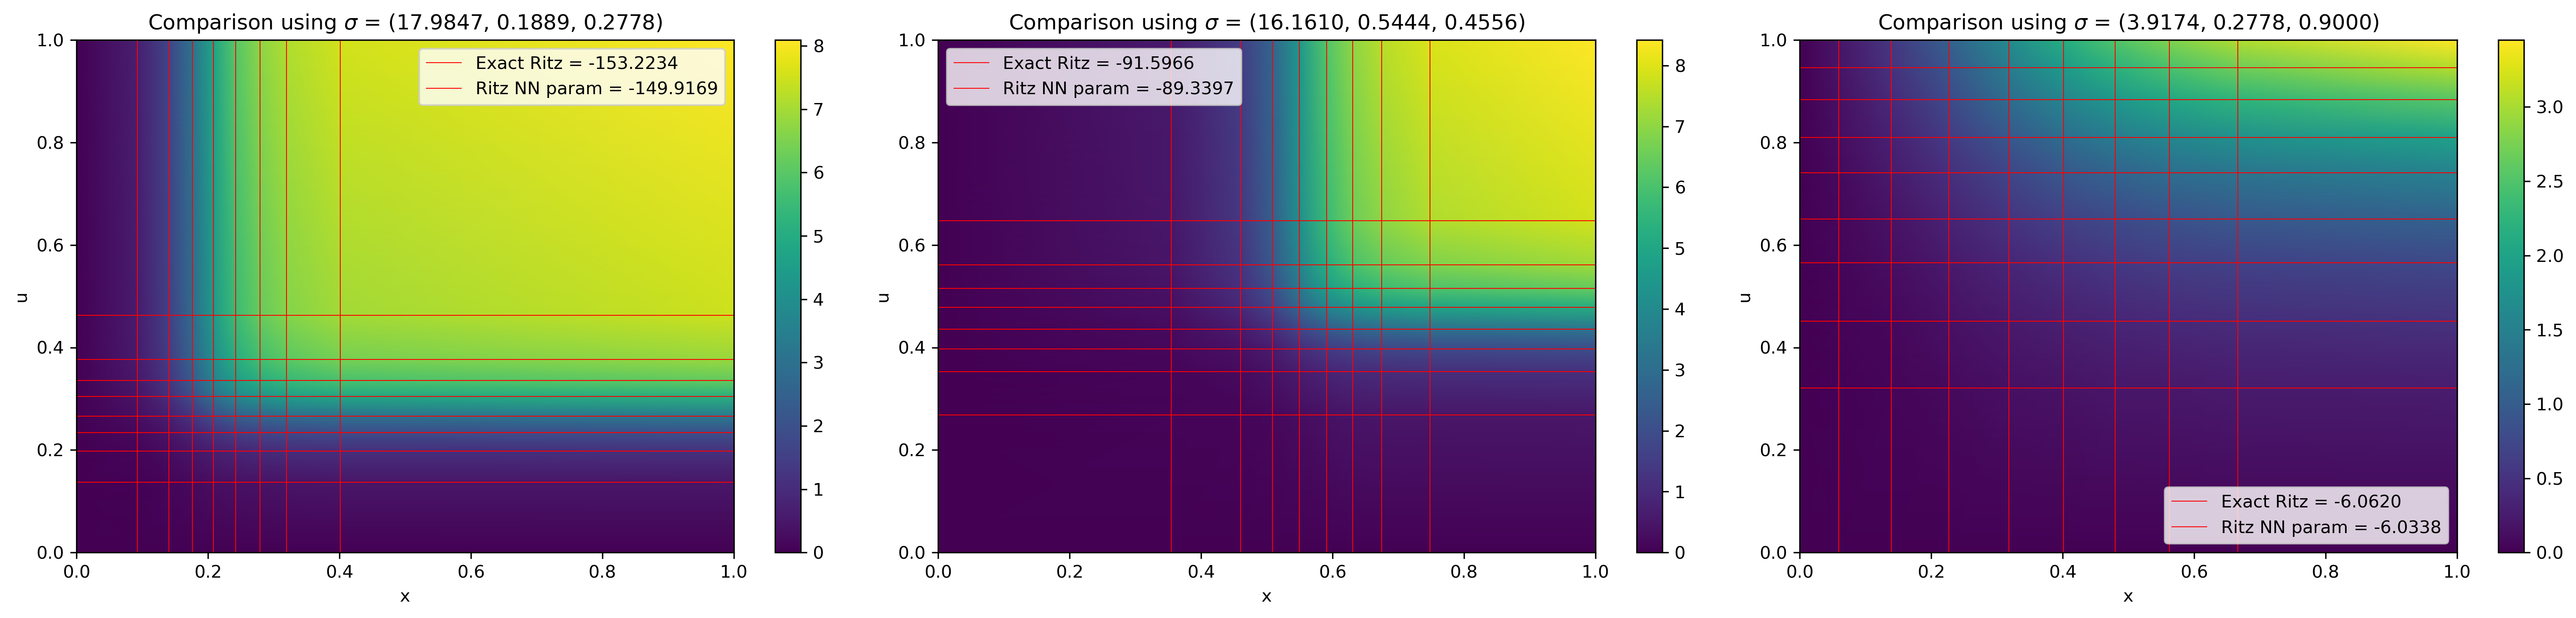

In [9]:
# Load data
special_test = np.array(pd.read_csv('Dataset/special_test.csv').values)

fig, axs = plt.subplots(1, 3, figsize=(21, 5), dpi=300)


for i in range(len(special_test)):
    nodes_fullNN, u_fullNN = FEM_sol(trained_param, special_test[i])
    
    ritz_fullNN = solve_and_loss(forward_pass(special_test[i], trained_param), special_test[i])
    exact_ritz_val = Exact_Ritz(np.array(special_test[i][0]), np.array(special_test[i][1]), np.array(special_test[i][2]))

    ax = axs[i]
    ax.pcolormesh(nodes_fullNN[:,0].reshape(n_nodes//2+1,n_nodes//2+1), 
                    nodes_fullNN[:,1].reshape(n_nodes//2+1,n_nodes//2+1), 
                    u_fullNN.reshape(n_nodes//2+1,n_nodes//2+1), shading='gouraud')

    ax.set_xlabel('x')
    ax.set_ylabel('u')
    unique_x = np.unique(nodes_fullNN[:,0])
    unique_y = np.unique(nodes_fullNN[:,1])
    for xi in unique_x:
        ax.plot([xi] * len(unique_y), unique_y, color='r', linewidth=0.5)  # Líneas verticales
    for yi in unique_y:
        ax.plot(unique_x, [yi] * len(unique_x), color='r', linewidth=0.5)  # Líneas horizontales
    fig.colorbar(ax.collections[0], ax=ax, orientation='vertical')
    ax.legend([f'Exact Ritz = {exact_ritz_val:.4f}', 
               f'Ritz NN param = {ritz_fullNN:.4f}',]) 
    ax.set_title(rf'Comparison using $\sigma$ = ({special_test[i][0]:.4f}, {special_test[i][1]:.4f}, {special_test[i][2]:.4f})')
    
plt.tight_layout()
plt.show()

In [10]:
# Evaluate the NN in every validation data and then compare the loss with the exact Ritz value

# List to save the Ritz values
ritz_validation       = []
exact_ritz_validation = []
error_validation      = []
rel_error_validation  = []
rel_uniform_val       = []

# Evaluate the NN in every validation data
for i in range(len(test_data)):
    if i % 100 == 0:
        print(f"Evaluating test data {i}/{len(test_data)}")
    
    # Calculate the Ritz value
    ritz = solve_and_loss_scipy(forward_pass(test_data[i,:], trained_param), test_data[i,:].reshape(-1, 3)).item()
    ritz_validation.append(ritz)
    
    # Calculate the exact Ritz value
    exact_ritz = Exact_Ritz(test_data[i,:][0], test_data[i,:][1], test_data[i,:][2])
    exact_ritz_validation.append(exact_ritz)
    exact_ritz_bal = exact_ritz / ritz_dict_val[str(test_data[i,:])]

    # Calculate the error
    error = np.sqrt(abs((ritz - exact_ritz)/ritz_dict_val[str(test_data[i,:])]))
    error_validation.append(error)

    # Calculate the relative error
    rel_error = error / np.sqrt(abs(exact_ritz_bal))
    rel_error_validation.append(rel_error)
    
    # Calculate the relative error with the uniform grid
    rel_error_uni = np.sqrt(abs( (ritz_dict_val[str(test_data[i,:])] - exact_ritz) / exact_ritz ))
    rel_uniform_val.append(rel_error_uni)

# Evaluate the NN in every training data and then compare the loss with the exact Ritz value

# List to save the Ritz values
ritz_train          = []
exact_ritz_train    = []
error_train         = []
rel_error_train     = []
rel_uniform_train   = []

# Evaluate the NN in every training data
for i in range(len(train_data)):
    if i % 100 == 0:
        print(f"Evaluating train data {i}/{len(train_data)}")
    
    # Calculate the Ritz value
    ritz = solve_and_loss_scipy(forward_pass(train_data[i,:], trained_param), train_data[i,:].reshape(-1, 3)).item()
    ritz_train.append(ritz)
    
    # Calculate the exact Ritz value
    exact_ritz = Exact_Ritz(train_data[i,:][0], train_data[i,:][1], train_data[i,:][2])
    exact_ritz_train.append(exact_ritz)
    exact_ritz_bal = exact_ritz / ritz_dict_train[str(train_data[i,:])]

    # Calculate the error
    error = np.sqrt(abs((ritz - exact_ritz)/ritz_dict_train[str(train_data[i,:])]))
    error_train.append(error)

    # Calculate the relative error
    rel_error = error / np.sqrt(abs(exact_ritz_bal))
    rel_error_train.append(rel_error)

    # Calculate the relative error with the uniform grid
    rel_error_uni = np.sqrt(abs( (ritz_dict_train[str(train_data[i,:])] - exact_ritz) / exact_ritz ))
    rel_uniform_train.append(rel_error_uni)

Evaluating test data 0/600
Evaluating test data 100/600
Evaluating test data 200/600
Evaluating test data 300/600
Evaluating test data 400/600
Evaluating test data 500/600
Evaluating train data 0/1400
Evaluating train data 100/1400
Evaluating train data 200/1400
Evaluating train data 300/1400
Evaluating train data 400/1400
Evaluating train data 500/1400
Evaluating train data 600/1400
Evaluating train data 700/1400
Evaluating train data 800/1400
Evaluating train data 900/1400
Evaluating train data 1000/1400
Evaluating train data 1100/1400
Evaluating train data 1200/1400
Evaluating train data 1300/1400


In [11]:
# Calcular estadísticas para el conjunto de entrenamiento
train_mean_abs_error = np.mean(error_train)
train_mean_rel_error = np.mean(rel_error_train)
train_std_abs_error = np.std(error_train)
train_std_rel_error = np.std(rel_error_train)
train_max_abs_error = np.max(error_train)
train_max_rel_error = np.max(rel_error_train)
train_uniform_mean_rel_error = np.mean(rel_uniform_train) 
train_uniform_max_rel_error = np.max(rel_uniform_train)

# Calcular estadísticas para el conjunto de validación
val_mean_abs_error = np.mean(error_validation)
val_mean_rel_error = np.mean(rel_error_validation)
val_std_abs_error = np.std(error_validation)
val_std_rel_error = np.std(rel_error_validation)
val_max_abs_error = np.max(error_validation)
val_max_rel_error = np.max(rel_error_validation)
val_uniform_mean_rel_error = np.mean(rel_uniform_val)
val_uniform_max_rel_error = np.max(rel_uniform_val)

# Crear un DataFrame con los resultados
data = {
    'Set': ['Train', 'Validation'],
    'Mean Absolute Error': [train_mean_abs_error, val_mean_abs_error],
    'Mean Relative Error': [train_mean_rel_error, val_mean_rel_error],
    'Std Absolute Error': [train_std_abs_error, val_std_abs_error],
    'Std Relative Error': [train_std_rel_error, val_std_rel_error],
    'Max Absolute Error': [train_max_abs_error, val_max_abs_error],
    'Max Relative Error': [train_max_rel_error, val_max_rel_error],
    'Uniform grid Mean Relative error': [train_uniform_mean_rel_error, val_uniform_mean_rel_error],
    'Uniform grid Max Relative error': [train_uniform_max_rel_error, val_uniform_max_rel_error]
}

df_errors = pd.DataFrame(data)
df_errors.to_csv('Error_result_N64.csv', index=False)
df_errors

,Set,Mean Absolute Error,Mean Relative Error,Std Absolute Error,Std Relative Error,Max Absolute Error,Max Relative Error,Uniform grid Mean Relative error,Uniform grid Max Relative error
0,Train,0.148234,0.140272,0.041693,0.037796,0.263353,0.234912,0.284233,0.457804
1,Validation,0.146364,0.138289,0.040970,0.037084,0.233855,0.211021,0.287926,0.454843
